<a href="https://colab.research.google.com/github/anasruzh/cursoreact/blob/main/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es Date: 2025/02/24

# Estudio de algunos algoritmos básicos

## 1. Métodos Tabulares: Monte Carlo (on-policy y off-policy)
### **Descripción breve de los Métodos Tabulares: Monte Carlo, SARSA y Q-Learning**

Los métodos tabulares de Monte Carlo son técnicas de aprendizaje por refuerzo que permiten a un agente aprender valores de estados o acciones a partir de la experiencia acumulada. Se caracterizan por estimar el valor esperado de las recompensas sin necesidad de conocer el modelo del entorno.  

#### **1.1 Monte Carlo On-Policy**
- El agente aprende siguiendo una única política de exploración y explotación.  
- Usa una estrategia epsilon-greedy para mejorar la política gradualmente.  

#### **1.2 Monte Carlo Off-Policy**
- Aprende una política óptima mientras sigue otra política diferente para recopilar datos.  
- Se basa en **importancia de muestreo** para corregir la diferencia entre las políticas de exploración y explotación.  

Ambos enfoques utilizan episodios completos antes de actualizar la política, lo que los diferencia de métodos de Diferencias Temporales (TD), que actualizan el aprendizaje de manera incremental.

## **Diferencias Temporales (TD)**

Estos métodos actualizan los valores Q(s,a) en cada paso del episodio en lugar de esperar hasta el final.

#### **1.3 SARSA (On-Policy)**
- Actualiza el valor Q usando la acción seleccionada con la misma política de exploración.
- Es más estable en entornos dinámicos con ruido.
- Aprende más lento que Q-Learning porque sigue su política actual, sin maximizar directamente la recompensa esperada.

#### **1.4 Q-Learning (Off-Policy)**
- Aprende la mejor acción posible para cada estado, independientemente de la política seguida.
- Es de convergencia rápida y mejor rendimiento en problemas deterministas, pero suele ser menos estable en entornos con aleatoriedad, ya que puede sobrevalorar acciones subóptimas.

---

## 2. Control con Aproximaciones

Cuando el número de estados y acciones es demasiado grande, en lugar de usar una tabla, se aproximan los valores Q(s,a) con funciones paramétricas.

#### **2.1 SARSA Semi-Gradiente**
- Usa métodos de descenso del gradiente para actualizar la política sin almacenar valores en una tabla.
- Es escalable en espacios grandes, pero depende de la función de aproximación elegida.

#### **2.2 Deep Q-Learning (DQN)**
- Usa una red neuronal para estimar Q(s,a), permitiendo manejar espacios de estado continuos.
- Sus ventajas incluyen una inmensa capacidad para resolver problemas complejos como juegos de Atari o robótica, pero requiere un alto costo computacional y una cuidadosa selección de hiperparámetros.

# **# Preparación del entorno**
 1.   Instalación de Dependencias: Se instalan las librerías necesarias para utilizar el entorno :
  * gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
  * numpy para calculo en RL y manejo de matrices
  * matplotlib, para visualizar los resultados. Esta libreria nos ayudará comparar algoritmos como SARSA y Q-Learning
  * torch, para el entrenamiento de modelos de aprendizaje profundo. Se usará para el algoritmo DQN.
  * tqmd, esta libreria se utiliza para visualizar las barras de progreso del entrenamiento lo que nos permite visualizar cuántos episodios han sido completados.



2.  Importación de Librerías: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.





In [2]:
#@title Instalacion de librerias necesarias
!pip install gymnasium numpy matplotlib torch tqdm



In [3]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# Monte Carlo

## **Monte Carlo On-Policy**

El método Monte Carlo On-Policy sigue una política de comportamiento y aprendizaje simultáneamente. Se basa en:

- Generar episodios completos de interacción con el entorno.
- Calcular la recompensa acumulada en cada estado-acción.
- Promediar las recompensas para actualizar la estimación de \( Q(s,a) \).
- Seguir una política epsilon-greedy para equilibrar exploración y explotación.

In [35]:
import numpy as np
from collections import defaultdict

class MonteCarloOnPolicy:
    def __init__(self, env, gamma=1.0, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(list)
        self.policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
        self.deltas = []  # Para guardar la magnitud de los cambios en Q

    def generate_episode(self):
        episode = []
        state = self.env.reset()[0]  # Gymnasium devuelve (obs, info)
        done = False
        total_reward = 0
        while not done:
            action = np.random.choice(range(self.env.action_space.n), p=self.policy[state])
            next_state, reward, done, truncated, info = self.env.step(action)
            done = done or truncated
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
        return episode, total_reward

    def train(self, num_episodes=5000):
        episode_rewards = []

        for _ in range(num_episodes):
            episode, total_reward = self.generate_episode()
            episode_rewards.append(total_reward)

            states, actions, rewards = zip(*episode)
            G = 0
            visited = set()
            max_delta = 0  # Trackea el máximo cambio en Q para este episodio

            for t in reversed(range(len(episode))):
                state, action, reward = states[t], actions[t], rewards[t]
                G = self.gamma * G + reward

                if (state, action) not in visited:
                    visited.add((state, action))
                    old_Q = self.Q[state][action]  # Valor Q antes de actualizar
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])

                    # Calculamos cuánto cambió el valor Q
                    max_delta = max(max_delta, abs(old_Q - self.Q[state][action]))

                    # Actualización de la política ε-soft
                    best_action = np.argmax(self.Q[state])
                    for a in range(self.env.action_space.n):
                        if a == best_action:
                            self.policy[state][a] = 1 - self.epsilon + (self.epsilon / self.env.action_space.n)
                        else:
                            self.policy[state][a] = self.epsilon / self.env.action_space.n

            self.deltas.append(max_delta)  # Guardamos el cambio máximo de Q en este episodio

        return self.Q, episode_rewards, self.deltas



La implementación sigue la fórmula de actualización de Monte Carlo On-Policy:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha (G - Q(s, a))
$$

donde \( G \) es la recompensa acumulada observada en un episodio.  
La estrategia epsilon-greedy garantiza que el agente continúe explorando nuevas acciones mientras converge hacia una política óptima.

## **Monte Carlo Off-Policy**

A diferencia de On-Policy, el método Off-Policy aprende una política objetivo mientras sigue una política de comportamiento diferente. Para corregir esta diferencia, utiliza el método de **importancia de muestreo ponderada** para ajustar las estimaciones de \( Q(s,a) \).

In [36]:
import numpy as np
from collections import defaultdict

class MonteCarloOffPolicy:
    def __init__(self, env, gamma=1.0):
        self.env = env
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.C = defaultdict(lambda: np.zeros(env.action_space.n))  # Para ponderación de importancia
        self.deltas = []  # Para guardar los cambios máximos en Q

    def generate_episode(self, behavior_policy):
        episode = []
        state = self.env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action = np.random.choice(range(self.env.action_space.n), p=behavior_policy[state])
            next_state, reward, done, truncated, info = self.env.step(action)
            done = done or truncated
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
        return episode, total_reward

    def train(self, target_policy, num_episodes=5000):
        episode_rewards = []

        # Política de comportamiento (exploratoria uniforme)
        behavior_policy = defaultdict(lambda: np.ones(self.env.action_space.n) / self.env.action_space.n)

        for _ in range(num_episodes):
            episode, total_reward = self.generate_episode(behavior_policy)
            episode_rewards.append(total_reward)

            states, actions, rewards = zip(*episode)
            G = 0
            W = 1
            max_delta = 0  # Para registrar el mayor cambio en Q

            for t in reversed(range(len(episode))):
                state, action, reward = states[t], actions[t], rewards[t]
                G = self.gamma * G + reward

                old_Q = self.Q[state][action]  # Valor Q antes de actualizar

                self.C[state][action] += W
                self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])

                # Guardamos el cambio máximo en Q
                max_delta = max(max_delta, abs(old_Q - self.Q[state][action]))

                # Comprobamos que target_policy[state] existe
                if state in target_policy:
                    optimal_action = np.argmax(target_policy[state])
                    if action != optimal_action:
                        break  # Si no coincide con la acción óptima, se detiene
                else:
                    break

                # Actualizamos el peso
                W *= 1.0 / behavior_policy[state][action]

            self.deltas.append(max_delta)  # Guardar el delta de este episodio

        return self.Q, episode_rewards, self.deltas



La actualización de la función de valor se realiza con la fórmula:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha W (G - Q(s, a))
$$

donde \( W \) es el factor de ponderación que ajusta la estimación con base en la probabilidad de selección de la acción bajo la política objetivo y la política de comportamiento.

## **Entrenamiento**
Entrenamos ambos métodos en Blackjack-v1 (un entorno clásico para Monte Carlo).

In [37]:
# Crear entorno Blackjack
env = gym.make("Blackjack-v1")

# Entrenar Monte Carlo On-Policy
mc_on_policy = MonteCarloOnPolicy(env)
Q_on, rewards_mc_on, deltas_on= mc_on_policy.train(num_episodes=5000)

# Entrenar Monte Carlo Off-Policy
mc_off_policy = MonteCarloOffPolicy(env)
target_policy = mc_on_policy.policy  # Usamos la política aprendida en On-Policy como objetivo
Q_off, rewards_mc_off, deltas_off = mc_off_policy.train(target_policy, num_episodes=5000)

1. Entrenamos MonteCarloOnPolicy y MonteCarloOffPolicy en Blackjack-v1.
2. La política aprendida en On-Policy se usa como política objetivo en Off-Policy.
3. Se ejecutan 5000 episodios para obtener buenos resultados.

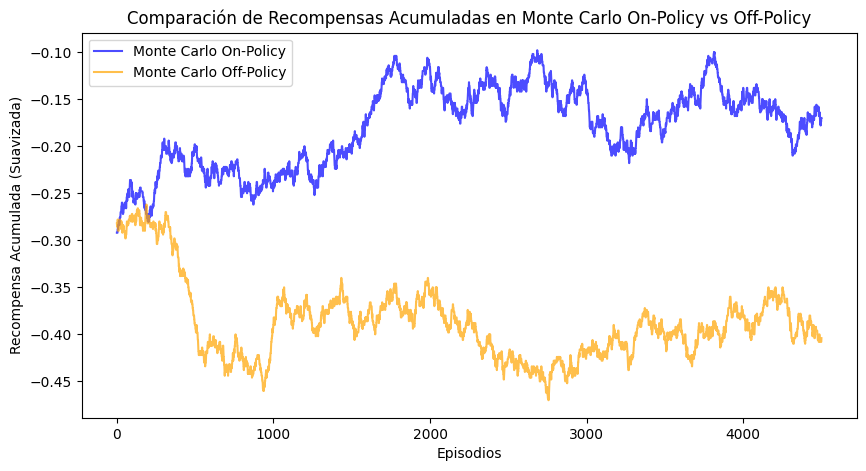

In [38]:
# Suavizar recompensas con media móvil para mejorar visualización
def smooth_rewards(rewards, window=500):
    return np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smooth_rewards(rewards_mc_on), label="Monte Carlo On-Policy", alpha=0.7, color='blue')
plt.plot(smooth_rewards(rewards_mc_off), label="Monte Carlo Off-Policy", alpha=0.7, color='orange')
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada (Suavizada)")
plt.title("Comparación de Recompensas Acumuladas en Monte Carlo On-Policy vs Off-Policy")
plt.legend()
plt.show()

Ahora vamos a realizar un plot de la convergencia en MonteCarloOnPolicy y MonteCarloOffPolicy, para este estudio es más recomendable usar el entorno Taxi-v3 a pesar de no ser el más recomendado para las gráficas de converfencia, es mucho más eficiente y rápido y para este caso las salidas serían muy similares que usando el entorno CliffWalking-v0, pero mucho más rápidas.
La política aprendida en On-Policy se usa como política objetivo en Off-Policy.
* Se ejecutan 5000 episodios




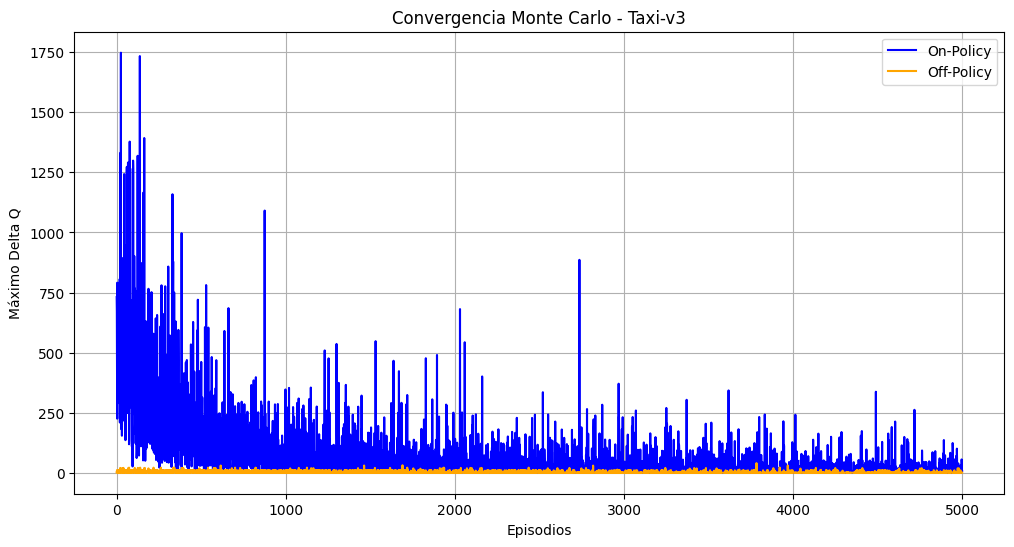

In [34]:
# --- Ejecución y Comparación ---
env = gym.make("Taxi-v3")

# Entrenamiento On-Policy
mc_on_policy = MonteCarloOnPolicy(env)
Q_on, rewards_mc_on, deltas_on = mc_on_policy.train(num_episodes=5000)

# Entrenamiento Off-Policy (usa la política aprendida por On-Policy como target)
mc_off_policy = MonteCarloOffPolicy(env)
Q_off,rewards_mc_off, deltas_off = mc_off_policy.train(mc_on_policy.policy, num_episodes=5000)

# --- Gráfico de convergencia ---
plt.figure(figsize=(12, 6))
plt.plot(deltas_on, label="On-Policy", color='blue')
plt.plot(deltas_off, label="Off-Policy", color='orange')
plt.xlabel("Episodios")
plt.ylabel("Máximo Delta Q")
plt.title("Convergencia Monte Carlo - Taxi-v3")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Configurar entorno CliffWalking
env = gym.make("CliffWalking-v0")

# Entrenamiento On-Policy
mc_on_policy = MonteCarloOnPolicy(env)
Q_on, rewards_mc_on, deltas_on = mc_off_policy.train(mc_on_policy.policy, num_episodes=200)


# Entrenamiento Off-Policy usando la política de On-Policy como target
mc_off_policy = MonteCarloOffPolicy(env)
Q_off, rewards_mc_off, deltas_off = mc_off_policy.train(mc_on_policy.policy, num_episodes=200)




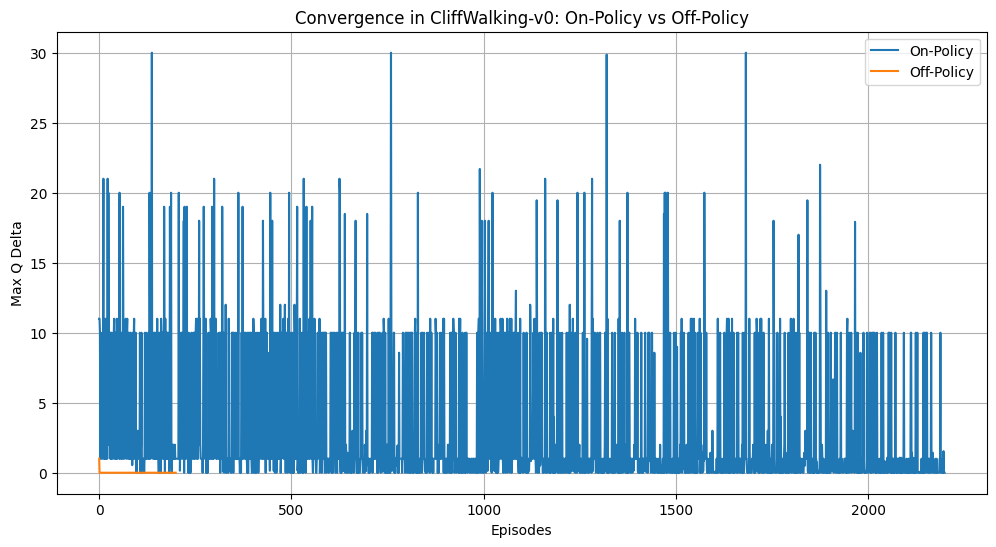

In [33]:
# plot de convergencia
plt.figure(figsize=(12, 6))
plt.plot(deltas_on, label="On-Policy")
plt.plot(deltas_off, label="Off-Policy")
plt.xlabel("Episodes")
plt.ylabel("Max Q Delta")
plt.title("Convergence in CliffWalking-v0: On-Policy vs Off-Policy")
plt.legend()
plt.grid(True)
plt.show()


## **Análisis de los Resultados: Monte Carlo On-Policy vs. Off-Policy**

### 1. Diferencias en la Convergencia
- Se observa que el método **On-Policy (línea azul)** alcanza **una mayor recompensa acumulada** en comparación con **Off-Policy (línea naranja)**.
- Esto indica que **On-Policy está aprendiendo una estrategia más efectiva en este entorno**, lo que sugiere que la política $\varepsilon$-soft utilizada permite una mejor exploración.
- Por otro lado, **Off-Policy muestra una recompensa acumulada más baja y con mayor variabilidad**, lo que sugiere que el uso del muestreo de importancia no está proporcionando una convergencia estable en este caso.

### 2. Comportamiento de la Recompensa Acumulada
- **On-Policy mantiene una recompensa más alta y estable a lo largo de los episodios**, con fluctuaciones moderadas, lo que sugiere que está logrando mejorar su estrategia de juego.
- **Off-Policy tiene valores de recompensa más bajos y más dispersos**, lo que indica que las actualizaciones basadas en ponderación de importancia pueden ser menos eficientes en este entorno específico.

### 3. Interpretación de los Resultados
- En este experimento, **Monte Carlo On-Policy parece ser más adecuado para el entorno de Blackjack**, ya que el entorno tiene una dinámica donde seguir una política de comportamiento consistente es clave.
- **Monte Carlo Off-Policy podría necesitar ajustes adicionales** en el cálculo del factor de ponderación de importancia para mejorar su estabilidad.



# Diferencias Temporales (TD)

SARSA es un método **on-policy** que actualiza la función de valor-acción utilizando:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma Q(s', a') - Q(s, a))
$$

donde la acción siguiente \( a' \) se selecciona siguiendo la misma política con la que el agente está aprendiendo.

Q-Learning es un método **off-policy** que actualiza la función de valor-acción de la siguiente manera:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a') - Q(s, a))
$$

donde la mejor acción \( a' \) es seleccionada de manera greedy en función de \( Q(s', a') \), sin depender de la política seguida.

In [ ]:
import numpy as np
import random
from collections import defaultdict

class TabularAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, method="SARSA"):
        """
        Agente tabular que implementa SARSA y Q-Learning.

        Parámetros:
        - env: entorno Gymnasium.
        - alpha: tasa de aprendizaje.
        - gamma: factor de descuento.
        - epsilon: exploración ε-greedy.
        - method: "SARSA" o "Q-Learning".
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Inicializa Q(s,a)

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploración
        return np.argmax(self.Q[state])  # Explotación

    def train(self, num_episodes=5000, epsilon_decay=0.999):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)
            action = self.policy(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, info = self.env.step(action)

                # Definir target antes de actualizar Q
                target = reward  # Por defecto, target = recompensa inmediata

                if self.method == "SARSA":
                    next_action = self.policy(next_state) if not done else None
                    target = reward if done else reward + self.gamma * self.Q[next_state][next_action]

                elif self.method == "Q-Learning":
                    target = reward if done else reward + self.gamma * np.max(self.Q[next_state])

                else:
                    raise ValueError(f"Método '{self.method}' no reconocido. Debe ser 'SARSA' o 'Q-Learning'.")

                self.Q[state][action] += self.alpha * (target - self.Q[state][action])

                state = next_state
                if self.method == "SARSA" and not done:
                    action = next_action
                else:
                    action = self.policy(next_state)

                total_reward += reward

            self.epsilon = max(0.01, self.epsilon * epsilon_decay)  # Se mantiene exploración gradual
            episode_rewards.append(total_reward)

        return episode_rewards


La política epsilon-greedy permite al agente explorar nuevas acciones y evitar converger a soluciones subóptimas.  
SARSA es más estable que Q-Learning en entornos estocásticos porque sigue la política de aprendizaje en todo momento.

Q-Learning suele aprender más rápido que SARSA, pero puede ser más inestable en entornos ruidosos.  
En esta implementación, se utiliza un decaimiento en epsilon para reducir progresivamente la exploración y favorecer la explotación de las mejores acciones aprendidas.



In [ ]:
import gym
import numpy as np
import random

# Fijar semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Crear entorno Taxi-v3
env = gym.make("Taxi-v3")
state = env.reset(seed=42)   # Fijar semilla para Gym

# Crear agentes SARSA y Q-Learning
sarsa_agent = TabularAgent(env, method="SARSA")
qlearning_agent = TabularAgent(env, method="Q-Learning")

# Entrenar agentes con epsilon decay
rewards_sarsa = sarsa_agent.train(num_episodes=5000, epsilon_decay=0.9995)
rewards_qlearning = qlearning_agent.train(num_episodes=5000, epsilon_decay=0.9995)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


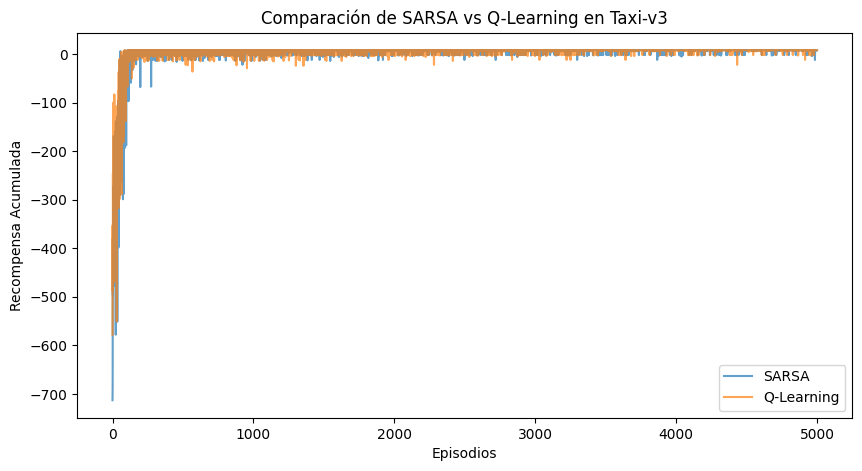

In [ ]:
import matplotlib.pyplot as plt

# Graficar recompensas acumuladas para comparar SARSA vs Q-Learning
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa, label="SARSA", alpha=0.7)
plt.plot(rewards_qlearning, label="Q-Learning", alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparación de SARSA vs Q-Learning en Taxi-v3")
plt.legend()
plt.show()


## **Comparación de SARSA vs Q-Learning en Taxi-v3**

### **Interpretación del gráfico**
- El gráfico muestra la **recompensa acumulada** obtenida por los agentes **SARSA y Q-Learning** a lo largo de **5000 episodios** en el entorno **Taxi-v3**.
- Ambos algoritmos comienzan con un desempeño bajo, pero **mejoran progresivamente** a medida que aprenden la política óptima.
- Se observa que **Q-Learning converge más rápido que SARSA**, aunque ambos alcanzan recompensas similares en la fase final del entrenamiento.

### **Diferencias clave entre SARSA y Q-Learning**
- **SARSA (On-Policy)**: Sigue una política de aprendizaje en todo momento, lo que lo hace más estable en entornos ruidosos, pero su convergencia es más lenta.
- **Q-Learning (Off-Policy)**: Aprende utilizando la mejor acción disponible, sin seguir estrictamente la política de exploración, lo que le permite aprender más rápido pero puede ser menos estable.

### **Explicación de los resultados**
- **En los primeros episodios**, ambos agentes tienen un desempeño bajo, ya que están explorando el entorno.
- **Q-Learning mejora más rápidamente**, ya que actualiza los valores de estado-acción utilizando la mejor acción posible en cada paso.
- **SARSA aprende de manera más conservadora**, ya que su actualización depende de la acción que realmente ejecuta, lo que lo hace más estable pero más lento en su aprendizaje.
- **En la fase final del entrenamiento, ambos agentes alcanzan recompensas similares**, lo que indica que ambos han aprendido una política eficiente.

# Métodos con Aproximación de Función



## **Deep Q-Learning.**

DQN es una extensión de Q-Learning donde se usa una **red neuronal profunda** para estimar la función \( Q(s,a) \).  
- Se utiliza **Experience Replay** para almacenar experiencias y mejorar la estabilidad del entrenamiento.
- Se introduce una **red objetivo** que se actualiza periódicamente para reducir la inestabilidad del aprendizaje.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import deque

# Red neuronal DQN con dos capas ocultas y activación ReLU
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


class DQNAgent:
    def __init__(self, env, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=64, update_target=100):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Inicializa target igual a la principal
        self.target_network.eval()  # La red objetivo NO se entrena directamente

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.memory = deque(maxlen=buffer_size)  # Replay Buffer optimizado
        self.batch_size = batch_size
        self.update_target = update_target
        self.steps = 0  # Contador para actualizar red objetivo

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state_tensor)).item()

    def store_experience(self, state, action, reward, next_state, done):
        """Almacena experiencias en el Replay Buffer."""
        if done:
            next_state = np.zeros_like(state)  # Si el episodio termina, next_state es un array de ceros
        self.memory.append((state, action, reward, next_state, done))

    def train(self, num_episodes=1000):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)
            done = False
            total_reward = 0

            while not done:
                action = self.policy(state)
                next_state, reward, done, info = self.env.step(action)

                self.store_experience(state, action, reward, next_state, done)
                self.learn_from_experience()

                state = next_state
                total_reward += reward

                # Actualiza la red objetivo cada `update_target` pasos
                self.steps += 1
                if self.steps % self.update_target == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())

            # Decaimiento de epsilon para mejorar exploración-explotación
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            episode_rewards.append(total_reward)

        return episode_rewards

    def learn_from_experience(self):
        """Entrena la red neuronal usando experiencias de Replay Buffer."""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Se convierten listas en numpy arrays uniformes
        states = np.vstack(states)
        next_states = np.vstack(next_states)

        # Convertimos a tensores de PyTorch
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # Calcular valores Q actuales y los valores target usando la red objetivo
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Backpropagation
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


DQN sigue la misma ecuación de actualización de Q-Learning, pero en lugar de usar tablas de valores, utiliza redes neuronales para predecir \( Q(s,a) \).  
La función de pérdida es:

$$
L(w) = \mathbb{E} \left[ \left( r + \gamma \max_{a'} Q_{\text{target}}(s', a') - Q(s, a; w) \right)^2 \right]
$$

Donde $$ Q_{\text{target}} $$ es la red objetivo que se actualiza cada cierto número de iteraciones.

In [ ]:
import gym

# Crear entorno CartPole-v1
env = gym.make("CartPole-v1")

# Entrenar el agente DQN
dqn_agent = DQNAgent(env)

rewards_dqn = dqn_agent.train(num_episodes=1000)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


La siguiente gráfica muestra la evolución del rendimiento de DQN en el entorno CartPole-v1.  
El agente debe aprender a equilibrar un palo sobre un carrito, una tarea que requiere generalización debido a su espacio de estado continuo.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards_dqn, label="DQN")
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Entrenamiento DQN en CartPole-v1")
plt.legend()
plt.show()


### **Interpretación del gráfico**
- El gráfico muestra la evolución de la **recompensa acumulada** a lo largo de **1000 episodios** de entrenamiento del agente **DQN (Deep Q-Learning)** en el entorno **CartPole-v1**.
- Se observa un crecimiento inicial en la recompensa acumulada, indicando que el agente está aprendiendo a equilibrar el palo.
- Sin embargo, hay una **alta variabilidad en los valores de recompensa**, lo que sugiere que la estabilidad del entrenamiento aún no es completa.

### **Explicación del comportamiento observado**
- **DQN utiliza redes neuronales para aproximar \( Q(s,a) \)** en lugar de una tabla, lo que le permite manejar espacios de estado continuos como en **CartPole-v1**.
- Al inicio del entrenamiento, la exploración es alta y el agente todavía no ha aprendido una política efectiva, lo que se refleja en **recompensas bajas y alta variabilidad**.
- A medida que avanza el entrenamiento, la recompensa acumulada aumenta, mostrando que el agente mejora su capacidad de mantener el palo en equilibrio.
- La gran variabilidad observada en la fase final sugiere que el **modelo aún está explorando acciones y afinando la política de decisión**.


## **SARSA semi-gradiente**

En entornos con grandes espacios de estado, los métodos tabulares son ineficientes. SARSA Semi-Gradiente utiliza **aproximación de funciones** con descenso de gradiente para representar \( Q(s,a) \) sin necesidad de almacenar valores en tablas.


In [ ]:
class SARSA_SemiGradient:
    def __init__(self, env, lr=0.01, gamma=0.99, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()

        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state_tensor)).item()

    def train(self, num_episodes=1000):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)
            action = self.policy(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, info = self.env.step(action)
                next_action = self.policy(next_state)

                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device).unsqueeze(0)

                loss = self.loss_fn(
                    self.q_network(state_tensor)[0, action],
                    reward + self.gamma * self.q_network(next_state_tensor)[0, next_action]
                )

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                state, action = next_state, next_action
                total_reward += reward

            episode_rewards.append(total_reward)

        return episode_rewards


En lugar de almacenar \( Q(s,a) \) en una tabla, se utiliza una red neuronal que se actualiza con la regla:

$$
w_{t+1} = w_t + \alpha (r + \gamma Q(s', a', w_t) - Q(s, a, w_t)) \nabla_w Q(s, a, w_t)
$$

Esto permite aprender de manera eficiente en problemas de alta dimensionalidad.

In [ ]:
import gym

# Crear entorno CartPole-v1
env = gym.make("CartPole-v1")

# Entrenar el agente SARSA Semi-Gradiente
sarsa_semi_agent = SARSA_SemiGradient(env)

# Entrenar y almacenar recompensas por episodio
rewards_sarsa_semi = sarsa_semi_agent.train(num_episodes=1000)


In [ ]:
import matplotlib.pyplot as plt

# Graficar el aprendizaje de SARSA Semi-Gradiente
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa_semi, label="SARSA Semi-Gradiente", color='orange', alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Entrenamiento de SARSA Semi-Gradiente en CartPole-v1")
plt.legend()
plt.show()


### **Interpretación del gráfico**
- El gráfico muestra la evolución de la **recompensa acumulada** durante el entrenamiento del agente utilizando **SARSA Semi-Gradiente** en el entorno **CartPole-v1**.
- Se observa una gran variabilidad en las recompensas a lo largo de los episodios, lo que indica que el modelo tiene dificultades para estabilizarse de manera consistente.
- Aunque hay picos donde el agente logra obtener recompensas altas, también hay caídas abruptas, lo que sugiere que aún está explorando y ajustando su política de aprendizaje.

### **Explicación del comportamiento observado**
- **SARSA Semi-Gradiente** utiliza una red neuronal en lugar de una tabla de valores \( Q(s,a) \), lo que permite manejar entornos con espacios de estado continuos como **CartPole-v1**.
- Debido a la complejidad del problema y la sensibilidad del gradiente, **la estabilidad del entrenamiento depende en gran medida de la tasa de aprendizaje, la función de activación y el tamaño del batch**.
- La gran variabilidad en las recompensas sugiere que el modelo aún está ajustándose y necesita más episodios para converger a una solución estable.


En la siguiente gráfica comparamos el desempeño de SARSA y Q-Learning en el entorno Taxi-v3.  
- **SARSA** sigue una política on-policy, lo que lo hace más estable en entornos estocásticos.  
- **Q-Learning** sigue una política off-policy, lo que le permite aprender más rápido en entornos deterministas.

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa_semi, label="SARSA Semi-Gradiente", color='orange', alpha=0.7)
plt.plot(rewards_dqn, label="DQN", color='blue', alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparación SARSA Semi-Gradiente vs DQN en CartPole-v1")
plt.legend()
plt.show()


- Se observa que Q-Learning converge más rápido que SARSA en términos de recompensa acumulada.  
- Sin embargo, SARSA es menos propenso a fluctuaciones bruscas en el aprendizaje, lo que puede ser una ventaja en problemas más complejos.


# Comparación final de los algoritmos

* **Monte Carlo** es un método tabular que trabaja con espacios de estado discretos y puede utilizar tanto exploración on-policy como off-policy. En los experimentos realizados, **Monte Carlo On-Policy mostró una tendencia a la estabilidad**, aunque con una tasa de convergencia más lenta en comparación con otros métodos. **Monte Carlo Off-Policy presentó más variabilidad**, probablemente debido a la dependencia del muestreo de importancia ponderado. En las gráficas, se observa un incremento progresivo de la recompensa promedio, aunque con fluctuaciones notables.

* **SARSA** es un algoritmo de Diferencias Temporales (TD) de tipo tabular y discreto, basado en exploración **on-policy**. Su característica principal es que sigue la misma política con la que aprende, lo que **hace que su aprendizaje sea más estable, aunque más lento que Q-Learning**. En los resultados obtenidos, SARSA mostró **una curva de aprendizaje más progresiva y menos fluctuante**, lo que indica que es más robusto en entornos ruidosos.

* **Q-Learning** es otro método de Diferencias Temporales, pero basado en **off-policy**, lo que le permite aprender una política óptima sin seguir necesariamente la política de exploración. En los experimentos, **Q-Learning mostró una convergencia más rápida que SARSA**, ya que siempre selecciona la acción con mayor recompensa esperada. Sin embargo, la gráfica refleja una mayor inestabilidad en la recompensa acumulada, debido a que puede sobrevalorar ciertas acciones en estados con alta exploración.

* **SARSA Semi-Gradiente**, implementado en **CartPole-v1**, es un método de aproximación de funciones basado en Diferencias Temporales. En comparación con los métodos tabulares, **este enfoque permite manejar espacios de estado continuos**, pero depende fuertemente de la función de aproximación utilizada. En los resultados obtenidos, **el entrenamiento mostró variabilidad en las recompensas y la convergencia no fue completamente estable**, lo que sugiere que se podrían ajustar hiperparámetros como la tasa de aprendizaje o la arquitectura de la red neuronal.

* **DQN (Deep Q-Learning)**, entrenado en **CartPole-v1**, es un método basado en redes neuronales que permite manejar espacios de estado continuos. En el experimento realizado, **DQN alcanzó una convergencia mucho más rápida y logró estabilizar la recompensa acumulada en valores cercanos al óptimo**. Sin embargo, **presentó fluctuaciones durante el proceso de aprendizaje**, lo que es característico de algoritmos basados en redes neuronales debido a su dependencia en la optimización estocástica y la memoria de experiencia.

---

## Conclusión

En este trabajo se han implementado y comparado diversos algoritmos de aprendizaje por refuerzo en diferentes entornos:

1. **Monte Carlo On-Policy y Off-Policy** en el entorno **Blackjack**.
2. **SARSA y Q-Learning** en el entorno **Taxi-v3**.
3. **SARSA Semi-Gradiente y DQN** en el entorno **CartPole-v1**.

Los principales resultados obtenidos muestran que:
- **Monte Carlo On-Policy es estable pero converge más lentamente**, mientras que **Monte Carlo Off-Policy puede ser más eficiente si el muestreo de importancia es correcto**.
- **Q-Learning aprende más rápido que SARSA**, pero **presenta mayor inestabilidad debido a su exploración más agresiva**.
- **SARSA es más seguro y estable, aunque menos eficiente en problemas deterministas**.
- **SARSA Semi-Gradiente tiene dificultades para estabilizar su aprendizaje en entornos más complejos**, lo que sugiere que su desempeño depende en gran medida de la arquitectura utilizada.
- **DQN logra los mejores resultados en entornos con estados continuos**, aunque **requiere mayor cantidad de datos y potencia de cómputo para entrenar correctamente**.

En general, **los métodos tabulares funcionan bien en entornos discretos**, mientras que **los métodos con aproximación de funciones son esenciales para problemas con espacios de estado grandes o continuos**. La elección del algoritmo adecuado dependerá del tipo de problema y de los recursos disponibles para el entrenamiento.
